#### Analyzing mobile prices

In our constantly evolving world the presence of mobile phones has become a fundamental part of our daily lives.
As we are exploring the digital world , choice of a mobile operating system serves as a compass.
There is two pillars that takes place in this battle **iOS** and **Android**.


In Swedish mobile market a constant duel between the two tech-giants takes place with each operating system competing for sumpremacy. Rather than diving into a subjective debate about which operating system is better (both systems delivers great user experience) we will take a more data - driven approach . We will investigate the Swedish market looking at the raw numbers and then hopefully help the average consumer (who are potentially intrested in buying  a new phone) to decide what model and what store are suited best for him.

Let us gather the data on mobile OS market in Sweden for 2023 from [Statcounter](https://gs.statcounter.com/os-market-share/mobile/sweden#monthly-202301-202312) which has been a reliable source for several years.
We will then import, melt and plot the data.

In [48]:
from requests_html import HTMLSession
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [49]:
data_os = pd.read_csv('os_combined-SE-monthly-202301-202312.csv')

In [50]:
data_os_melted = pd.melt(data_os ,
                         id_vars=['Date'] ,
                         value_vars= ['iOS', 'Android'] ,
                         var_name='OS',
                         value_name ='Percentage')




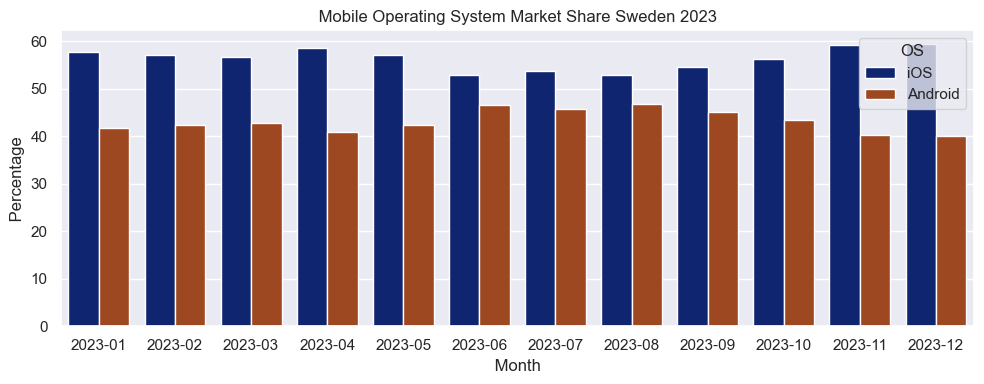

In [51]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 4))
sns.barplot(x='Date', y='Percentage', hue='OS', data=data_os_melted, palette='dark')
plt.title(' Mobile Operating System Market Share Sweden 2023 ')
plt.xlabel(' Month ')
plt.ylabel(' Percentage ')
plt.tight_layout()
plt.show()

As we can see there are more iOS users in Sweden. Important to keep in mind that this is generally not true. Worldwide data shows that there are more android users (probably due its open platform nature). If we would take a look at the data from India for 2023 there are approximately only 5 % (on average) that uses iOS. Its intresting because maybe there is some correlation between a country life quality index and the distribution between iOS / Android users. However , interesting as the thought may be , it is not on todays agenda.

Our concern is Sweden so let us proceed. We want now to gather price data for the latest iphone models which is as for today 
iphone 15. We will examine 3 models:

* Iphone 15 pro max (256 gb)
* Iphone pro (256 gb)
* Iphone 15 (256 gb)

The way that we gather data will be Webscraping. The problem that one will likely face when webscraping prices from different 
stores is that the most of such websites are non static meaning that the websites dont has its content explicitly in its static HTML. Such (dynamic) websites uses server-side to display data that is based on users actions ( like clickling or scrolling).
Dynamic websites uses JavaScript to dynamically load the content.

This means that one will have to use specific libraries for webscraping dynamic content.
One such library is **Selenium**. It uses a webdriver to simulate user interaction with a website (like clicking buttons) and are able to execute the content loaded by JavaScript. And this is exaclty what we will use. 

We will define a set of functions that webscrape data from different websites.
We will webscrape the most popular stores in Sweden:

* Tele2
* Elgiganten
* Power (former MediaMarkt)
* Swappie 

Since i used a library that was not inlcluded in this course and for demonstration sake i will briefly describe it.

In [34]:

def scrape_power_product(url,df):
   
    driver = webdriver.Chrome()  # initialize webdriver (chrome)
    driver.get(url) #opens url in webdriver

    
    driver.implicitly_wait(1) #make sure dynamiccontent is loaded

    # find name and price element by xpath
    name_element = driver.find_element(By.XPATH, '//h1[@data-testid="product-title"]')
    price_element = driver.find_element(By.XPATH, '//pwr-price[@type="integer"]')

    #extract the data from name/price elements
    product_name = name_element.text
    product_price = price_element.text

    #create a df
    new_df = pd.DataFrame({'Name': [product_name], 'Price': [product_price], 'Store': ['Power']})
    # append to df
    df = pd.concat([df, new_df], ignore_index=True)
    
    #close webdriver
    driver.quit()

    return df


In short we are opening a webbrowser simulating user behaviour, extracting all the relevant data with
**XPATH**, appending the data to the dataframe that we will create and closing the webbrowser ( works similar as closing the connection for sql). We are using XPATh to locate the html elements like **h1** or **pwr-price**.

In [18]:
def tele2(url, nameclass, priceclass, df):
    driver = webdriver.Chrome()
    driver.get(url)

    name_xpath = f'//h1[@class="{nameclass}"]'
    price_xpath = f'//span[@class="{priceclass}"]'

    name = driver.find_elements(By.XPATH, name_xpath)[0].text
    price = driver.find_elements(By.XPATH, price_xpath)[3].text    
    
    data = {'Name': [name], 'Price': [price], 'Store': ['Tele2']}
    new_df = pd.DataFrame(data)

    df = pd.concat([df, new_df], ignore_index=True)

    driver.quit()
    
    return df




def elgiganten(url, df):
    driver = webdriver.Chrome()
    driver.get(url)

    driver.implicitly_wait(1)

    name_element = driver.find_element(By.XPATH, '//h1[@class="product-title"]')
    price_element = driver.find_element(By.XPATH, '//p[@class="feature__price ng-star-inserted"]')

    product_name = name_element.text
    product_price = price_element.text

    new_df = pd.DataFrame({'Name': [product_name], 'Price': [product_price], 'Store': ['Elgiganten']})
    
    df = pd.concat([df, new_df], ignore_index=True)
    driver.quit()

    return df

def swappie(url, df):
    driver = webdriver.Chrome()
    driver.get(url)

    driver.implicitly_wait(10)

    name_element = driver.find_element(By.XPATH, '//h1[contains(@class, "ModelHeading__ModelTitle")]')
    price_element = driver.find_element(By.XPATH, '//p[starts-with(@class, "ModelPrice-c3dgcx-0")]')

    product_name = driver.execute_script("return arguments[0].textContent;", name_element)
    product_price = price_element.text

    new_df = pd.DataFrame({'Name': [product_name], 'Price': [product_price], 'Store': ['swappie']})

    df = pd.concat([df, new_df], ignore_index=True)

    driver.quit()

    return df



After gathering all the data we get the following dataframe

In [35]:
df = pd.DataFrame(columns=['Name', 'Price', 'Store'])


In [36]:
# iphone 15 pro max
df = tele2('https://www.tele2.se/mobilt/mobiler/apple/apple-iphone-15-pro-max',
           "sc-AxiKw kjgJkm sc-jHENFz MdEin",
           "sc-AxiKw gwtVJl sc-kHzJJj knCQVN",
           df)

# iphone 15
df = tele2('https://www.tele2.se/mobilt/mobiler/apple/apple-iphone-15',
           "sc-AxiKw kjgJkm sc-jHENFz MdEin",
           "sc-AxiKw gwtVJl sc-kHzJJj knCQVN",
           df)

# iphone 15 pro
df = tele2('https://www.tele2.se/mobilt/mobiler/apple/apple-iphone-15-pro',
           "sc-AxiKw kjgJkm sc-jHENFz MdEin",
           "sc-AxiKw gwtVJl sc-kHzJJj knCQVN",
           df)

# Print the resulting DataFrame

In [37]:

#iphone pro max 15
df = scrape_power_product('https://www.power.se/mobil-och-foto/mobiltelefoner/apple-iphone-15-pro-max-256-gb-naturligt-titan/p-2668280/',df)


#iphone pro 15
df = scrape_power_product('https://www.power.se/mobil-och-foto/mobiltelefoner/apple-iphone-15-pro-256-gb-naturligt-titan/p-2668268/',df)

df = scrape_power_product('https://www.power.se/mobil-och-foto/mobiltelefoner/apple-iphone-15-256-gb-svart/p-2668237/',df)

In [38]:

#iphone 15 pro max
df = elgiganten('https://www.elgiganten.se/product/mobiler-tablets-smartklockor/mobiltelefon/iphone-15-pro-max-5g-smartphone-256gb-svart-titan/673003',
                df)
#iphone 15 pro
df = elgiganten('https://www.elgiganten.se/product/mobiler-tablets-smartklockor/mobiltelefon/iphone-15-pro-5g-smartphone-256gb-svart-titan/673015',
                df)

#iphone 15
df = elgiganten('https://www.elgiganten.se/product/mobiler-tablets-smartklockor/mobiltelefon/iphone-15-5g-smartphone-256gb-gul/672999',
                df)


In [39]:
#Iphone 15 pro max 
df = swappie('https://swappie.com/se/iphone/iphone-15-pro-max/iphone-15-pro-max-256gb-naturligt-titan-18/',df)

#Iphone 15 pro
df = swappie('https://swappie.com/se/modell/iphone-15-pro/',df)

#Iphone 15
df = swappie('https://swappie.com/se/modell/iphone-15/',df)

In [52]:
df

                                                 Name      Price       Store
0                                   iPhone 15 Pro Max  16 236 kr       Tele2
1                                           iPhone 15  10 836 kr       Tele2
2                                       iPhone 15 Pro  13 356 kr       Tele2
3      APPLE IPHONE 15 PRO MAX 256 GB NATURLIGT TITAN      17990       Power
4          APPLE IPHONE 15 PRO 256 GB NATURLIGT TITAN      15990       Power
5                       APPLE IPHONE 15 256 GB, SVART      13490       Power
6   iPhone 15 Pro Max 5G smartphone 256GB svart titan    17990.-  Elgiganten
7       iPhone 15 Pro 5G smartphone 256GB svart titan    15990.-  Elgiganten
8                 iPhone 15 – 5G smartphone 256GB gul    13490.-  Elgiganten
9                                   iPhone 15 Pro Max  16 679 kr     swappie
10                                      iPhone 15 Pro  14 999 kr     swappie
11                                          iPhone 15  11 639 kr     swappie

Now lets work and clean our dataset. Not all the rows has numeric type for instance.
When we did webscraping we automatically got names that were longer than needed and the price column
is not automatically in the numeric format. Let us change that before operating with the dataset.

Also, just in case, we will create a copy of our data so that if anything unusual happens
we can be safe. We will define a function that takes care of all the model names and also 
get rid of all non numeric characters in the price column and convert the rest to the numeric type.

In [41]:
df_copy3 = df.copy()

In [42]:
def map_name(name):
    name_lower = name.lower()
    if 'pro max' in name_lower:
        return 'iPhone 15 Pro Max'
    elif 'pro' in name_lower:
        return 'iPhone 15 Pro'
    elif 'iphone 15' in name_lower:
        return 'iPhone 15'
    else:
        return name

df_copy3['Name'] = df_copy3['Name'].apply(map_name)

# Remove non-numeric characters from 'Price' column and convert to numeric
df_copy3['Price'] = pd.to_numeric(df_copy3['Price'].astype(str).replace('[^0-9.]', '', regex=True), errors='coerce')

In [53]:
df_copy3

                 Name    Price       Store
0   iPhone 15 Pro Max  16236.0       Tele2
1           iPhone 15  10836.0       Tele2
2       iPhone 15 Pro  13356.0       Tele2
3   iPhone 15 Pro Max  17990.0       Power
4       iPhone 15 Pro  15990.0       Power
5           iPhone 15  13490.0       Power
6   iPhone 15 Pro Max  17990.0  Elgiganten
7       iPhone 15 Pro  15990.0  Elgiganten
8           iPhone 15  13490.0  Elgiganten
9   iPhone 15 Pro Max  16679.0     swappie
10      iPhone 15 Pro  14999.0     swappie
11          iPhone 15  11639.0     swappie

Now lets visualize what we have done.

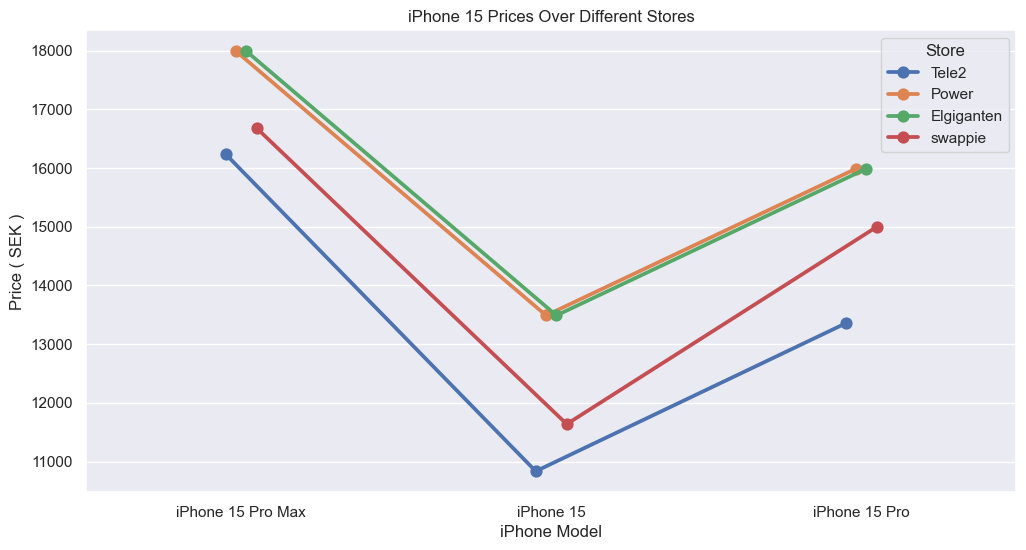

In [56]:
sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))

sns.pointplot(x='Name', y='Price', hue='Store', data=df_copy3, palette='deep', dodge=True, markers='o', capsize=0.2)
plt.title('iPhone 15 Prices Over Different Stores')
plt.xlabel('iPhone Model')
plt.ylabel('Price ( SEK )')
plt.show()

As we can see Tele2 seem to beat every other store in price aspect.
Tele2 is a reliable store with good insurance on their products so 
if you are planning on buying a new iphone it is worth consider it as an option.

#### Sources 

https://www.zenrows.com/blog/dynamic-web-pages-scraping-python


https://gs.statcounter.com/os-market-share/mobile/worldwide

In [63]:
!jupyter nbconvert --to markdown --TagRemovePreprocessor.remove_cell_tags='{"hide_code"}' Databehandling_projekt_final.ipynb


C:\Users\Admin\anaconda3\lib\site-packages\traitlets\traitlets.py:2544: FutureWarning: Supporting extra quotes around strings is deprecated in traitlets 5.0. You can use 'hide_code' instead of "'hide_code'" if you require traitlets >=5.
  warn(
[NbConvertApp] Converting notebook Databehandling_projekt_final.ipynb to markdown
[NbConvertApp] Support files will be in Databehandling_projekt_final_files\
[NbConvertApp] Making directory Databehandling_projekt_final_files
[NbConvertApp] Making directory Databehandling_projekt_final_files
[NbConvertApp] Writing 7695 bytes to Databehandling_projekt_final.md
